In [1]:
dataset_name = 'SOTS-outdoor'
DEBUG_FLAG = False

In [2]:
import os
import math
import argparse
import gc
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch.autograd import Variable

In [3]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, dataset_name):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    last_num = None
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                # select the most hazed images in SOTS-indoor
                if dataset_name=='SOTS-indoor' and '_' in fname and '_10' not in fname:
                    continue
                # skip images saved in temp folder
                if '.ipynb_checkpoints' in root:
                    continue
                # dedup for SOTS-outdoor
                if dataset_name=='SOTS-outdoor':
                    num = fname.split('_')[0]
                    if num == last_num:
                        continue
                    last_num = num
                path = os.path.join(root, fname)
                images.append(path)
    return images

In [4]:
## Dataset loader

def resize_img(img):
    im_w, im_h = img.size
    # resize the big image to save the gpu memory
    size_limit = 1024
    while im_w > size_limit or im_h > size_limit:
        img = img.resize((int(im_w // 2), int(im_h // 2)))  
        im_w, im_h = img.size
    # resize the image into multiple of 4
    if im_w % 4 != 0 or im_h % 4 != 0:
        img = img.resize((int(im_w // 4 * 4), int(im_h // 4 * 4))) 
        im_w, im_h = img.size
    return img

result_cache = {}
def dataset_loader(name):
    """
    Load the dataset into the memory
    name: 'I-HAZY', 'O-HAZY', 'SOTS-indoor', 'SOTS-outdoor'
    """
    if name in result_cache:
        return result_cache[name]
    else:
        hazy_path = {
            'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
            'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
            'SOTS-indoor' : 'SOTS/indoor/hazy',
            'SOTS-outdoor' : 'SOTS/outdoor/hazy',
        }
        clear_path = {
            'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
            'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
            'SOTS-indoor' : 'SOTS/indoor/clear',
            'SOTS-outdoor' : 'SOTS/outdoor/clear',        
        }
        train_img_paths = make_dataset('dataset/'+hazy_path[name], name)
        truth_img_paths = make_dataset('dataset/'+clear_path[name], name)
        result = []
        for train_path, truth_path in zip(train_img_paths, truth_img_paths):
            train_img = resize_img(Image.open(train_path).convert('RGB'))
            truth_img = resize_img(Image.open(truth_path).convert('RGB'))
            result.append((train_img, truth_img))
        result_cache[name] = result
        return result

In [5]:
def psnr(target, ref):
    # convert image into float64
    target_data = np.array(target, dtype=np.float64)
    ref_data = np.array(ref,dtype=np.float64)
    # calculate difference
    diff = ref_data - target_data
    # flatten the rgb channels
    diff = diff.flatten('C')
    # calculate RSE
    rmse = math.sqrt(np.mean(diff ** 2.))
    # precision
    eps = np.finfo(np.float64).eps
    if(rmse == 0):
        rmse = eps 
    return 20*math.log10(255.0/rmse)

import pytorch_ssim
def ssim(img1,img2):
    img1 = torch.from_numpy(np.rollaxis(np.array(img1), 2)).float().unsqueeze(0)/255.0
    img2 = torch.from_numpy(np.rollaxis(np.array(img2), 2)).float().unsqueeze(0)/255.0   
    img1 = Variable(img1, requires_grad=False)    # torch.Size([256, 256, 3])
    img2 = Variable(img2, requires_grad=False)
    ssim_value = pytorch_ssim.ssim(img1, img2).item()
    return ssim_value

In [6]:
## debug dataset paths
if DEBUG_FLAG:
    hazy_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
        'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
        'SOTS-indoor' : 'SOTS/indoor/hazy',
        'SOTS-outdoor' : 'SOTS/outdoor/hazy',
    }
    clear_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
        'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
        'SOTS-indoor' : 'SOTS/indoor/clear',
        'SOTS-outdoor' : 'SOTS/outdoor/clear',        
    }
    for path1, path2 in zip(make_dataset('dataset/'+hazy_path[dataset_name], dataset_name), make_dataset('dataset/'+clear_path[dataset_name], dataset_name)):
        print(path1 + '        ' + path2)

In [7]:
## GCA-Net

def GCA_benchmark(dataset):
    def edge_compute(x):
        x_diffx = torch.abs(x[:,:,1:] - x[:,:,:-1])
        x_diffy = torch.abs(x[:,1:,:] - x[:,:-1,:])

        y = x.new(x.size())
        y.fill_(0)
        y[:,:,1:] += x_diffx
        y[:,:,:-1] += x_diffx
        y[:,1:,:] += x_diffy
        y[:,:-1,:] += x_diffy
        y = torch.sum(y,0,keepdim=True)/3
        y /= 4
        return y

    GCA_psnr = []
    GCA_ssim = []
    GCA_resultimg = []
    from GCANet.GCANet import GCANet
    net = GCANet(in_c=4, out_c=3, only_residual=True).cuda()
    net.load_state_dict(torch.load('GCANet/models/wacv_gcanet_dehaze.pth', map_location='cpu'))
    net.eval()
    for img, truth in tqdm(dataset):
        img = np.array(img).astype('float')
        img_data = torch.from_numpy(img.transpose((2, 0, 1))).float()
        in_img = Image.fromarray(img_data.numpy().astype(np.uint8).transpose(1, 2, 0))
        edge_data = edge_compute(img_data)
        in_data = torch.cat((img_data, edge_data), dim=0).unsqueeze(0) - 128 
        in_data = in_data.cuda()
        with torch.no_grad():
            pred = net(Variable(in_data))
        out_img_data = (pred.data[0].cpu().float() + img_data).round().clamp(0, 255)
        out_img = Image.fromarray(out_img_data.numpy().astype(np.uint8).transpose(1, 2, 0))
        psnr_value = psnr(out_img, truth)
        ssim_value = ssim(out_img, truth)
        GCA_psnr.append(psnr_value)
        GCA_ssim.append(ssim_value)
        GCA_resultimg.append(out_img)
    return GCA_psnr, GCA_ssim, GCA_resultimg

GCA_psnr, GCA_ssim, GCA_resultimg = GCA_benchmark(dataset_loader(dataset_name))
print(f'average psnr: {np.mean(GCA_psnr)}   average ssim: {np.mean(GCA_ssim)}')    
gc.collect()
torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [03:46<00:00,  2.18it/s]

average psnr: 23.119155964212023   average ssim: 0.9252043974593402


In [8]:
## FFA-Net
import torchvision.transforms as tfs 
from FFANet.net.models import FFA

def FFA_benchmark(dataset):
    ckp=torch.load('FFANet/net/trained_models/'+
                   ('its_train_ffa_3_19.pk' if 'indoor' in dataset_name or 'I' in dataset_name else 'ots_train_ffa_3_19.pk')
                   ,map_location='cpu')
    net=FFA(gps=3,blocks=19)
    net=torch.nn.DataParallel(net)
    net.load_state_dict(ckp['model'])
    net.eval()
    FFA_psnr = []
    FFA_ssim = []
    FFA_resultimg = []
    for img, truth in tqdm(dataset):
        haze1= tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])
        ])(img)[None,::]
        with torch.no_grad():
            pred = net(haze1)
        ts=(torch.squeeze(pred.clamp(0,1)*255.0).cpu()).round()
        out_img = Image.fromarray(ts.numpy().astype(np.uint8).transpose(1, 2, 0))
        psnr_value = psnr(out_img, truth)
        ssim_value = ssim(out_img, truth)
        FFA_psnr.append(psnr_value)
        FFA_ssim.append(ssim_value)
        FFA_resultimg.append(out_img)
    return FFA_psnr, FFA_ssim, FFA_resultimg

FFA_psnr, FFA_ssim, FFA_resultimg = FFA_benchmark(dataset_loader(dataset_name))
print(f'average psnr: {np.mean(FFA_psnr)}   average ssim: {np.mean(FFA_ssim)}')
gc.collect()
torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [07:29<00:00,  1.09it/s]

average psnr: 31.35033396003099   average ssim: 0.9777673435647313


In [9]:
### Matlab results
def OCA_benchmark(datset_name):
    hazy_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
        'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
        'SOTS-indoor' : 'SOTS/indoor/hazy',
        'SOTS-outdoor' : 'SOTS/outdoor/hazy',
    }
    result_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018',
        'O-HAZY' : '# O-HAZY NTIRE 2018',
        'SOTS-indoor' : 'SOTS/indoor',
        'SOTS-outdoor' : 'SOTS/outdoor',        
    }
    clear_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
        'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
        'SOTS-indoor' : 'SOTS/indoor/clear',
        'SOTS-outdoor' : 'SOTS/outdoor/clear',        
    }
    OPC_psnr = []
    OPC_ssim = []
    OPC_resultimg = []
    train_img_paths = make_dataset('dataset/'+hazy_path[dataset_name], dataset_name)
    result_img_paths = make_dataset('opc_output/'+result_path[dataset_name], dataset_name)
    truth_img_paths = make_dataset('dataset/'+clear_path[dataset_name], dataset_name)
    for train_path, result_path, truth_path in tqdm(list(zip(train_img_paths, result_img_paths, truth_img_paths))):
        train_img = resize_img(Image.open(train_path).convert('RGB'))
        result_img = resize_img(Image.open(result_path).convert('RGB'))
        truth_img = resize_img(Image.open(truth_path).convert('RGB'))
        psnr_value = psnr(result_img, truth_img)
        ssim_value = ssim(result_img, truth_img)
        OPC_psnr.append(psnr_value)
        OPC_ssim.append(ssim_value)
        OPC_resultimg.append(result_img)
    return OPC_psnr, OPC_ssim, OPC_resultimg

OPC_psnr, OPC_ssim, OPC_resultimg = OCA_benchmark(dataset_name)
print(f'average psnr: {np.mean(OPC_psnr)}   average ssim: {np.mean(OPC_ssim)}')
gc.collect()
torch.cuda.empty_cache()

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [03:17<00:00,  2.49it/s]

average psnr: 16.930461126156356   average ssim: 0.8049939152428774


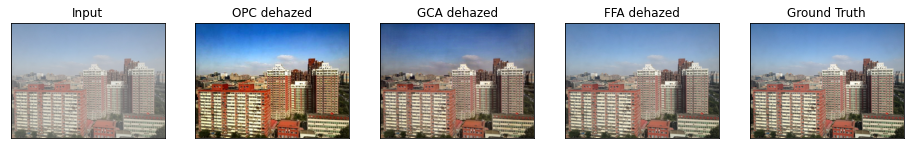

OPC psnr: 19.839973048740337   OPC ssim: 0.88351970911026
GCA psnr: 19.716481983602158   GCA ssim: 0.936651885509491
FFA psnr: 30.392793998091747   FFA ssim: 0.9821413159370422


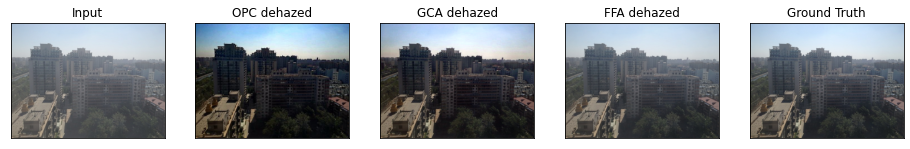

OPC psnr: 15.739144341698728   OPC ssim: 0.7138247489929199
GCA psnr: 19.44021439242005   GCA ssim: 0.878415048122406
FFA psnr: 32.14781999838485   FFA ssim: 0.9880729913711548


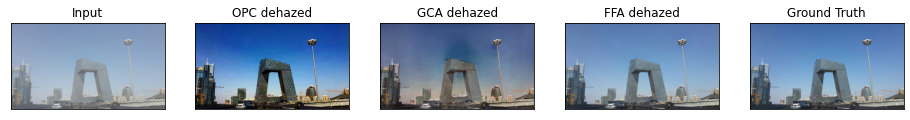

OPC psnr: 17.068193963569172   OPC ssim: 0.8098134994506836
GCA psnr: 18.372735195535952   GCA ssim: 0.940574586391449
FFA psnr: 29.530161096393552   FFA ssim: 0.9858983755111694


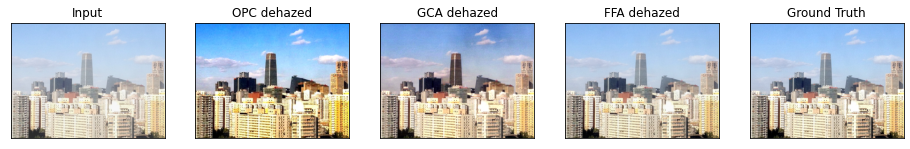

OPC psnr: 17.969181332685576   OPC ssim: 0.869720995426178
GCA psnr: 20.43932461795852   GCA ssim: 0.9466884732246399
FFA psnr: 34.88814917133563   FFA ssim: 0.9893577098846436


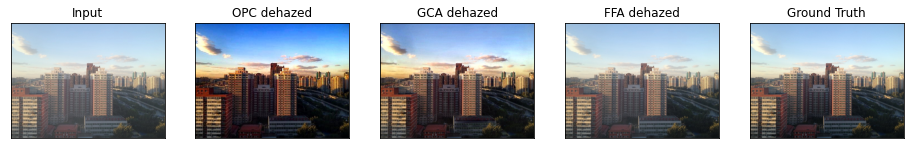

OPC psnr: 15.907749992623327   OPC ssim: 0.7950983643531799
GCA psnr: 21.6337052175343   GCA ssim: 0.9228241443634033
FFA psnr: 26.528518101876056   FFA ssim: 0.9648942351341248


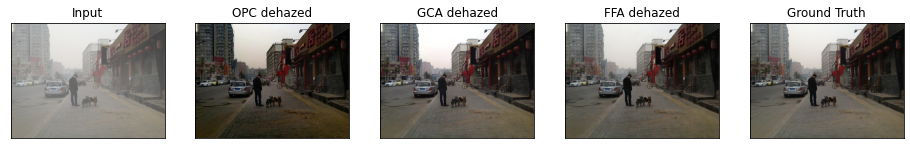

OPC psnr: 16.02726453887349   OPC ssim: 0.7833335399627686
GCA psnr: 27.660750432337156   GCA ssim: 0.9685801863670349
FFA psnr: 29.398139541593142   FFA ssim: 0.9782221913337708


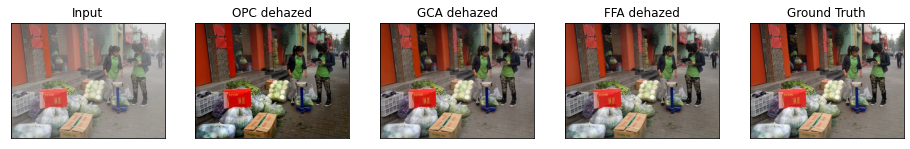

OPC psnr: 16.884243228383305   OPC ssim: 0.8062661290168762
GCA psnr: 26.430702676078806   GCA ssim: 0.9526452422142029
FFA psnr: 26.898879464799677   FFA ssim: 0.9624522924423218


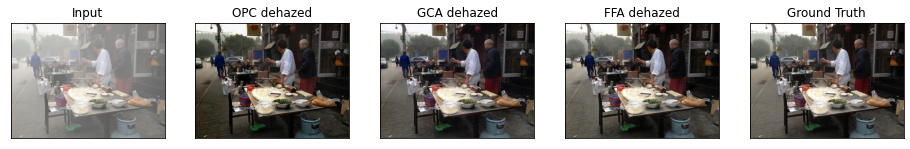

OPC psnr: 19.377679091325394   OPC ssim: 0.8573039174079895
GCA psnr: 26.391338060626033   GCA ssim: 0.9537962079048157
FFA psnr: 28.86094742972383   FFA ssim: 0.9565470218658447


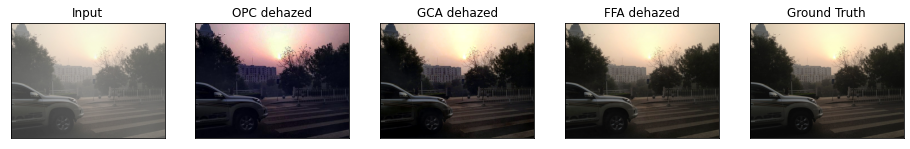

OPC psnr: 20.223082772892745   OPC ssim: 0.8249061107635498
GCA psnr: 25.487502328306114   GCA ssim: 0.8534015417098999
FFA psnr: 37.653638563022554   FFA ssim: 0.9847318530082703


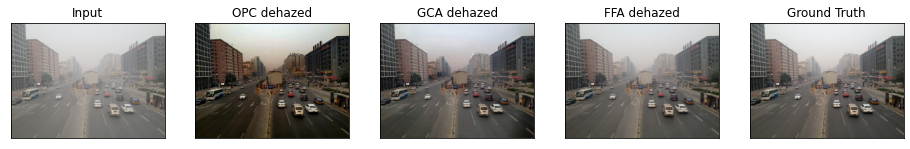

OPC psnr: 15.251430904373217   OPC ssim: 0.7547696232795715
GCA psnr: 22.58482768700315   GCA ssim: 0.9584315419197083
FFA psnr: 29.85527039115955   FFA ssim: 0.9842132329940796


In [10]:
# generate partial of results    
for i, (img, truth) in enumerate(dataset_loader(dataset_name)[:10]):
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    ax1.imshow(img)
    ax2.imshow(OPC_resultimg[i])
    ax3.imshow(GCA_resultimg[i])
    ax4.imshow(FFA_resultimg[i])
    ax5.imshow(truth)
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.set_xticks([])
        ax.set_yticks([])
    ax1.title.set_text('Input')
    ax2.title.set_text('OPC dehazed')
    ax3.title.set_text('GCA dehazed')
    ax4.title.set_text('FFA dehazed')
    ax5.title.set_text('Ground Truth')
    plt.show()
    print(f'OPC psnr: {OPC_psnr[i]}   OPC ssim: {OPC_ssim[i]}')
    print(f'GCA psnr: {GCA_psnr[i]}   GCA ssim: {GCA_ssim[i]}')
    print(f'FFA psnr: {FFA_psnr[i]}   FFA ssim: {FFA_ssim[i]}')

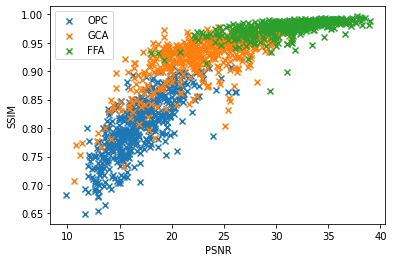

In [11]:
plt.scatter(OPC_psnr, OPC_ssim, marker='x')
plt.scatter(GCA_psnr, GCA_ssim, marker='x')
plt.scatter(FFA_psnr, FFA_ssim, marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(['OPC','GCA', 'FFA'])
plt.show() 